In [ ]:
%%capture
!python -m spacy download en
!python -m spacy download de

# preprocessing

In [ ]:
import spacy

spacy_en = spacy.load('en') # 영어 토큰화(tokenization)
spacy_de = spacy.load('de') # 독일어 토큰화(tokenization)

In [ ]:
# 독일어(Deutsch) 문장을 토큰화 하는 함수 (순서를 뒤집지 않음)
def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

# 영어(English) 문장을 토큰화 하는 함수
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

# dataset

In [ ]:
from torchtext.data import Field, BucketIterator

SRC = Field(tokenize=tokenize_de, init_token="", eos_token="", lower=True)
TRG = Field(tokenize=tokenize_en, init_token="", eos_token="", lower=True)

In [ ]:
from torchtext.datasets import Multi30k

train_dataset, valid_dataset, test_dataset = Multi30k.splits(exts=(".de", ".en"), fields=(SRC, TRG))

SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

# 일반적인 데이터 로더(data loader)의 iterator와 유사하게 사용 가능
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device=device)

# architecture

In [ ]:
import torch.nn as nn

# 인코더(Encoder) 아키텍처 정의
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, enc_hidden_dim, dec_hidden_dim, dropout_ratio):
        super().__init__()

        # 임베딩(embedding)은 원-핫 인코딩(one-hot encoding)을 특정 차원의 임베딩으로 매핑하는 레이어
        self.embedding = nn.Embedding(input_dim, embed_dim)

        # 양방향(bidirectional) GRU 레이어
        self.rnn = nn.GRU(embed_dim, enc_hidden_dim, bidirectional=True)

        # FC 레이어
        self.fc = nn.Linear(enc_hidden_dim * 2, dec_hidden_dim)

        # 드롭아웃(dropout)
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더는 소스 문장을 입력으로 받아 문맥 벡터(context vector)를 반환        
    def forward(self, src):
        # src: [단어 개수, 배치 크기]: 각 단어의 인덱스(index) 정보
        embedded = self.dropout(self.embedding(src))
        # embedded: [단어 개수, 배치 크기, 임베딩 차원]

        outputs, hidden = self.rnn(embedded)
        # outputs: [단어 개수, 배치 크기, 인코더 히든 차원 * 방향의 수]: 전체 단어의 출력 정보
        # hidden: [레이어 개수 * 방향의 수, 배치 크기, 인코더 히든 차원]: 현재까지의 모든 단어의 정보

        # hidden은 [forward_1, backward_1, forward_2, backward_2, ...] 형태로 구성
        # 따라서 hidden[-2, :, :]은 forwards의 마지막 값
        # 따라서 hidden[-1, :, :]은 backwards의 마지막 값
        # 디코더(decoder)의 첫 번째 hidden (context) vector는 인코더의 마지막 hidden을 이용
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))

        # outputs은 Attention 목적으로, hidden은 context vector 목적으로 사용
        return outputs, hidden
    
import torch.nn.functional as F

# 어텐션(Attention) 아키텍처 정의
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()

        self.attn = nn.Linear((enc_hidden_dim * 2) + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, enc_outputs):
        # hidden: [배치 크기, 히든 차원]: 현재까지의 모든 단어의 정보
        # enc_outputs: [단어 개수, 배치 크기, 인코더 히든 차원 * 방향의 수]: 전체 단어의 출력 정보
        batch_size = enc_outputs.shape[1]
        src_len = enc_outputs.shape[0]

        # 현재 디코더의 히든 상태(hidden state)를 src_len만큼 반복
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        enc_outputs = enc_outputs.permute(1, 0, 2)
        # hidden: [배치 크기, 단어 개수, 디코더 히든 차원]: 현재까지의 모든 단어의 정보
        # enc_outputs: [배치 크기, 단어 개수, 인코더 히든 차원 * 방향의 수]: 전체 단어의 출력 정보

        energy = torch.tanh(self.attn(torch.cat((hidden, enc_outputs), dim=2)))
        # energy: [배치 크기, 단어 개수, 디코더 히든 차원]

        attention = self.v(energy).squeeze(2)
        # attention: [배치 크기, 단어 개수]: 실제 각 단어에 대한 어텐선(attention) 값들

        return F.softmax(attention, dim=1)
    
# 디코더(Decoder) 아키텍처 정의
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, enc_hidden_dim, dec_hidden_dim, dropout_ratio, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention

        # 임베딩(embedding)은 원-핫 인코딩(one-hot encoding) 말고 특정 차원의 임베딩으로 매핑하는 레이어
        self.embedding = nn.Embedding(output_dim, embed_dim)

        # GRU 레이어
        self.rnn = nn.GRU((enc_hidden_dim * 2) + embed_dim, dec_hidden_dim)

        # FC 레이어
        self.fc_out = nn.Linear((enc_hidden_dim * 2) + dec_hidden_dim + embed_dim, output_dim)
        
        # 드롭아웃(dropout)
        self.dropout = nn.Dropout(dropout_ratio)

    # 디코더는 현재까지 출력된 문장에 대한 정보를 입력으로 받아 타겟 문장을 반환     
    def forward(self, input, hidden, enc_outputs):
        # input: [배치 크기]: 단어의 개수는 항상 1개이도록 구현
        # hidden: [배치 크기, 히든 차원]
        # enc_outputs: [단어 개수, 배치 크기, 인코더 히든 차원 * 방향의 수]: 전체 단어의 출력 정보
        input = input.unsqueeze(0)
        # input: [단어 개수 = 1, 배치 크기]

        embedded = self.dropout(self.embedding(input))
        # embedded: [단어 개수 = 1, 배치 크기, 임베딩 차원]

        attention = self.attention(hidden, enc_outputs)
        # attention: [배치 크기, 단어 개수]: 실제 각 단어에 대한 어텐선(attention) 값들
        attention = attention.unsqueeze(1)
        # attention: [배치 크기, 1, 단어 개수]: 실제 각 단어에 대한 어텐선(attention) 값들

        enc_outputs = enc_outputs.permute(1, 0, 2)
        # enc_outputs: [배치 크기, 단어 개수, 인코더 히든 차원 * 방향의 수]: 전체 단어의 출력 정보

        weighted = torch.bmm(attention, enc_outputs) # 행렬 곱 함수
        # weighted: [배치 크기, 1, 인코더 히든 차원 * 방향의 수]

        weighted = weighted.permute(1, 0, 2)
        # weighted: [1, 배치 크기, 인코더 히든 차원 * 방향의 수]
        
        rnn_input = torch.cat((embedded, weighted), dim=2)
        # rnn_input: [1, 배치 크기, 인코더 히든 차원 * 방향의 수 + embed_dim]: 어텐션이 적용된 현재 단어 입력 정보
        
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output: [단어 개수, 배치 크기, 디코더 히든 차원 * 방향의 수]
        # hidden: [레이어 개수 * 방향의 수, 배치 크기, 디코더 히든 차원]: 현재까지의 모든 단어의 정보

        # 현재 예제에서는 단어 개수, 레이어 개수, 방향의 수 모두 1의 값을 가짐
        # 따라서 output: [1, 배치 크기, 디코더 히든 차원], hidden: [1, 배치 크기, 디코더 히든 차원]
        # 다시 말해 output과 hidden의 값 또한 동일
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        # prediction = [배치 크기, 출력 차원]
        
        # (현재 출력 단어, 현재까지의 모든 단어의 정보)
        return prediction, hidden.squeeze(0)
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    # 학습할 때는 완전한 형태의 소스 문장, 타겟 문장, teacher_forcing_ratio를 넣기
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: [단어 개수, 배치 크기]
        # trg: [단어 개수, 배치 크기]
        # 먼저 인코더를 거쳐 전체 출력과 문맥 벡터(context vector)를 추출
        enc_outputs, hidden = self.encoder(src)

        # 디코더(decoder)의 최종 결과를 담을 텐서 객체 만들기
        trg_len = trg.shape[0] # 단어 개수
        batch_size = trg.shape[1] # 배치 크기
        trg_vocab_size = self.decoder.output_dim # 출력 차원
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # 첫 번째 입력은 항상  토큰
        input = trg[0, :]

        # 타겟 단어의 개수만큼 반복하여 디코더에 포워딩(forwarding)
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, enc_outputs)

            outputs[t] = output # FC를 거쳐서 나온 현재의 출력 단어 정보
            top1 = output.argmax(1) # 가장 확률이 높은 단어의 인덱스 추출

            # teacher_forcing_ratio: 학습할 때 실제 목표 출력(ground-truth)을 사용하는 비율
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[t] if teacher_force else top1 # 현재의 출력 결과를 다음 입력에서 넣기

        return outputs

# train

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENCODER_EMBED_DIM = 256
DECODER_EMBED_DIM = 256
ENCODER_HIDDEN_DIM = 512
DECODER_HIDDEN_DIM = 512
ENC_DROPOUT_RATIO = 0.5
DEC_DROPOUT_RATIO = 0.5

# 어텐션(attention) 객체 선언
attn = Attention(ENCODER_HIDDEN_DIM, DECODER_HIDDEN_DIM)

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, ENCODER_EMBED_DIM, ENCODER_HIDDEN_DIM, DECODER_HIDDEN_DIM, ENC_DROPOUT_RATIO)
dec = Decoder(OUTPUT_DIM, DECODER_EMBED_DIM, ENCODER_HIDDEN_DIM, DECODER_HIDDEN_DIM, DEC_DROPOUT_RATIO, attn)

# Seq2Seq 객체 선언
model = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

import torch.optim as optim

# Adam optimizer로 학습 최적화
optimizer = optim.Adam(model.parameters())

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
     

# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0
    
    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()

        output = model(src, trg)
        # output: [출력 단어 개수, 배치 크기, 출력 차원]
        output_dim = output.shape[-1]
        
        # 출력 단어의 인덱스 0은 사용하지 않음
        output = output[1:].view(-1, output_dim)
        # output = [(출력 단어의 개수 - 1) * batch size, output dim]
        trg = trg[1:].view(-1)
        # trg = [(타겟 단어의 개수 - 1) * batch size]
        
        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산
        
        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # 파라미터 업데이트
        optimizer.step()
        
        # 전체 손실 값 계산
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0
    
    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # 평가할 때 teacher forcing는 사용하지 않음
            output = model(src, trg, 0)
            # output: [출력 단어 개수, 배치 크기, 출력 차원]
            output_dim = output.shape[-1]
            
            # 출력 단어의 인덱스 0은 사용하지 않음
            output = output[1:].view(-1, output_dim)
            # output = [(출력 단어의 개수 - 1) * batch size, output dim]
            trg = trg[1:].view(-1)
            # trg = [(타겟 단어의 개수 - 1) * batch size]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'seq2seq_with_attention.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

In [ ]:
# 학습된 모델 저장
from google.colab import files

files.download('seq2seq_with_attention.pt')

model.load_state_dict(torch.load('seq2seq_with_attention.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

## Prep

### Libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import random
import time
import re
import os
import io

print(tf.__version__)

2.6.0


In [3]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

### Read data

In [4]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 118964
Example:
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


### Prepreocess text

In [5]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip() #lower casing

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 특수 문자 기준 좌우 공백
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러 개의 공백을 하나로
    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence) # 알파벳+허용된 특수문자만 남기고 공백처리

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [6]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
    eng, spa = pair.split("\t")

    enc_corpus.append(preprocess_sentence(eng))
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True))

print("English:", enc_corpus[100])   # go away !
print("Spanish:", dec_corpus[100])   # <start> salga de aqu ! <end>

English: go away !
Spanish: <start> salga de aqu ! <end>


### Tokenization

In [7]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [8]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# train/validation split
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Spanish Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 4931
Spanish Vocab Size: 8893


## Model structure
![](https://d3s0tskafalll9.cloudfront.net/media/images/GN-4-P-2.max-800x600.jpg)

![](https://wikidocs.net/images/page/160003/6_gHyQZ4bFEoDkTbMZkptuYA.png)

In [9]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc) # encoder hidden state
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec) # decoder hidden state

        score = self.w_com(tf.nn.tanh(h_dec + h_enc)) # attention score 
        
        attn = tf.nn.softmax(score, axis=1) # attention weight

        context_vec = attn * h_enc 
        context_vec = tf.reduce_sum(context_vec, axis=1) # context vector

        return context_vec, attn

In [36]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, 
                                                   embedding_dim,
                                                   dropout=0.5)
        # self.bigru = tf.keras.layers.Bidirection(tf.keras.layers.LSTM(enc_units,
                                       # return_sequences=True)))
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [11]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       dropout=0.5)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.dropout = tf.keras.layers.Dropout(0.5) # Maxout

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)
        out = self.dropout(out)

        return out, h_dec, attn

### Preview input-output dimensions

In [12]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 8894)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


### Optimizer & Loss

In [13]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# metric = bleuscore
 

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

## Train & evaluate

### Train function

### Evaluation

In [17]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 94/94 [00:04<00:00, 22.42it/s, Test Loss 0.8469]


/tmp/ipykernel_185/1426363336.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_185/1426363336.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: can i have some coffee ?
Predicted translation: me das un poco de caf ? <end> 


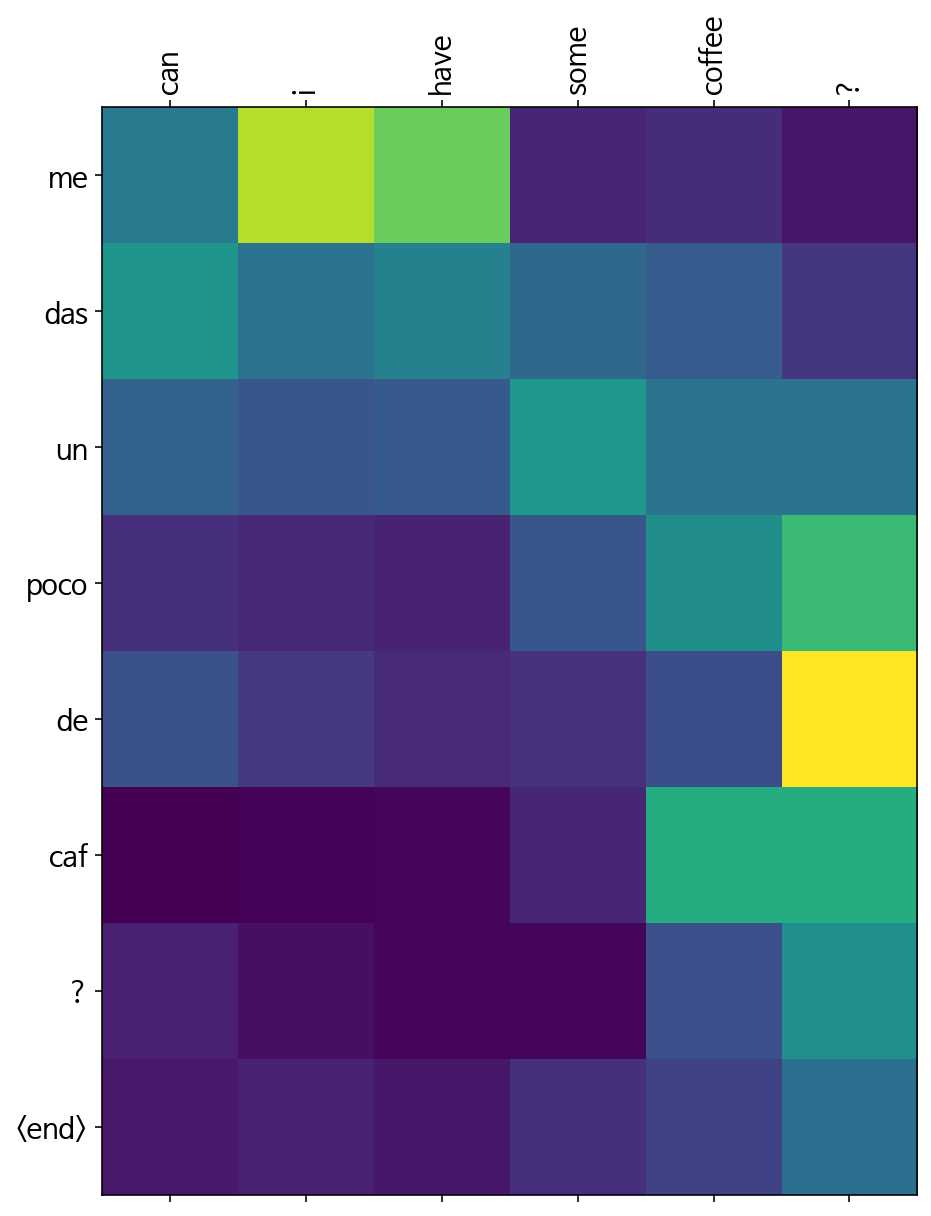

In [18]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("Can I have some coffee?", encoder, decoder)

Input: how are you ?
Predicted translation: qu tal ? <end> 


/tmp/ipykernel_185/1426363336.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_185/1426363336.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


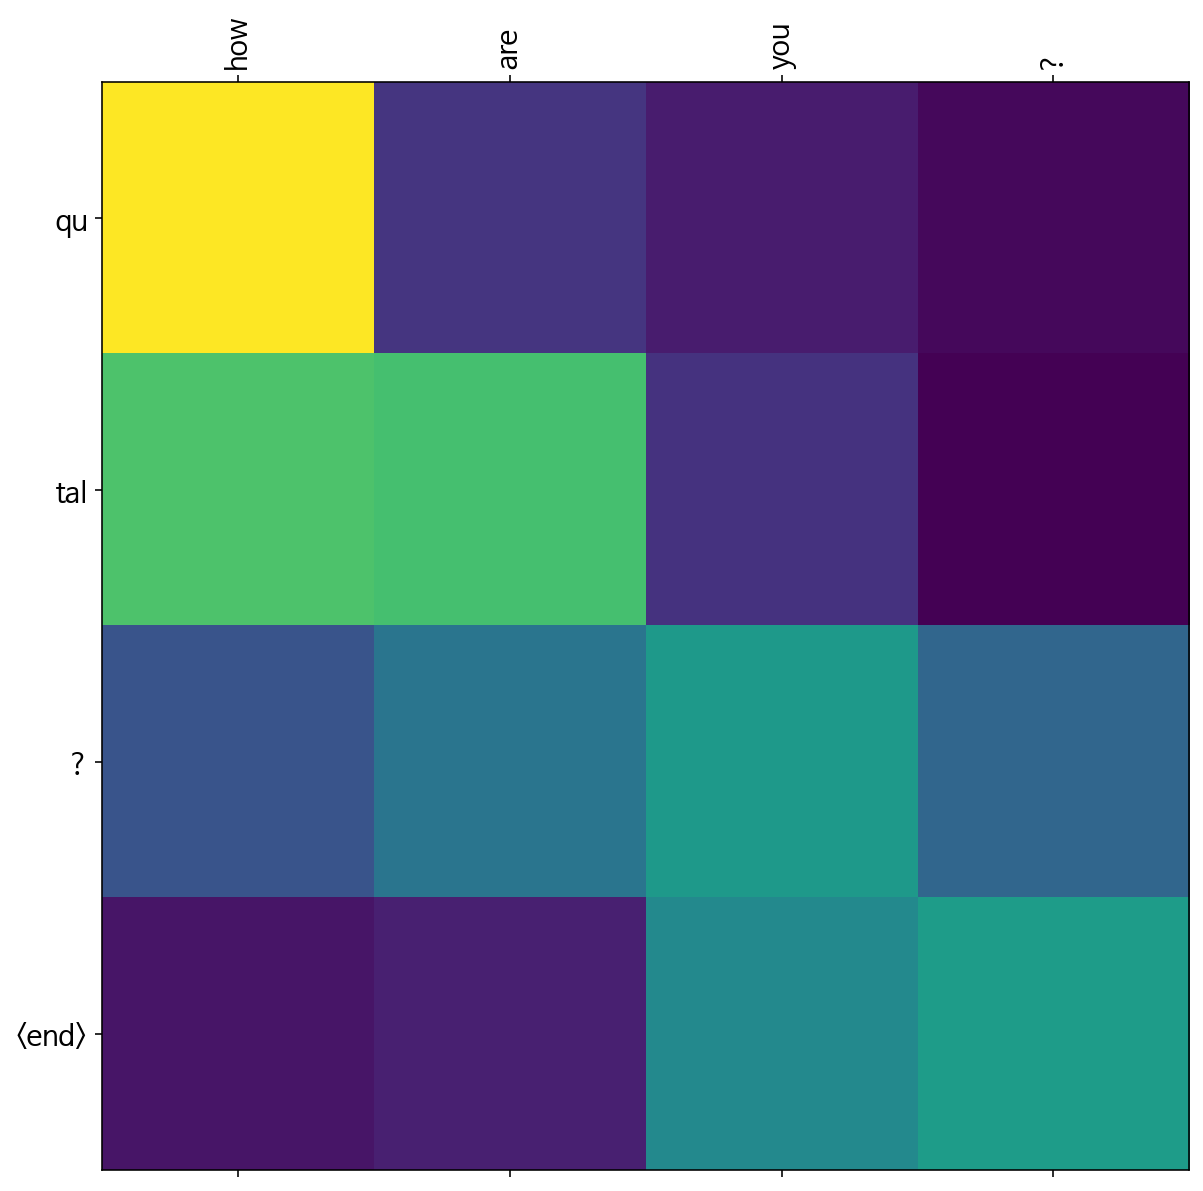

In [20]:
translate("How are you?", encoder, decoder)

Input: nice to meet you .
Predicted translation: qu date conmigo . <end> 


/tmp/ipykernel_185/1426363336.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_185/1426363336.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


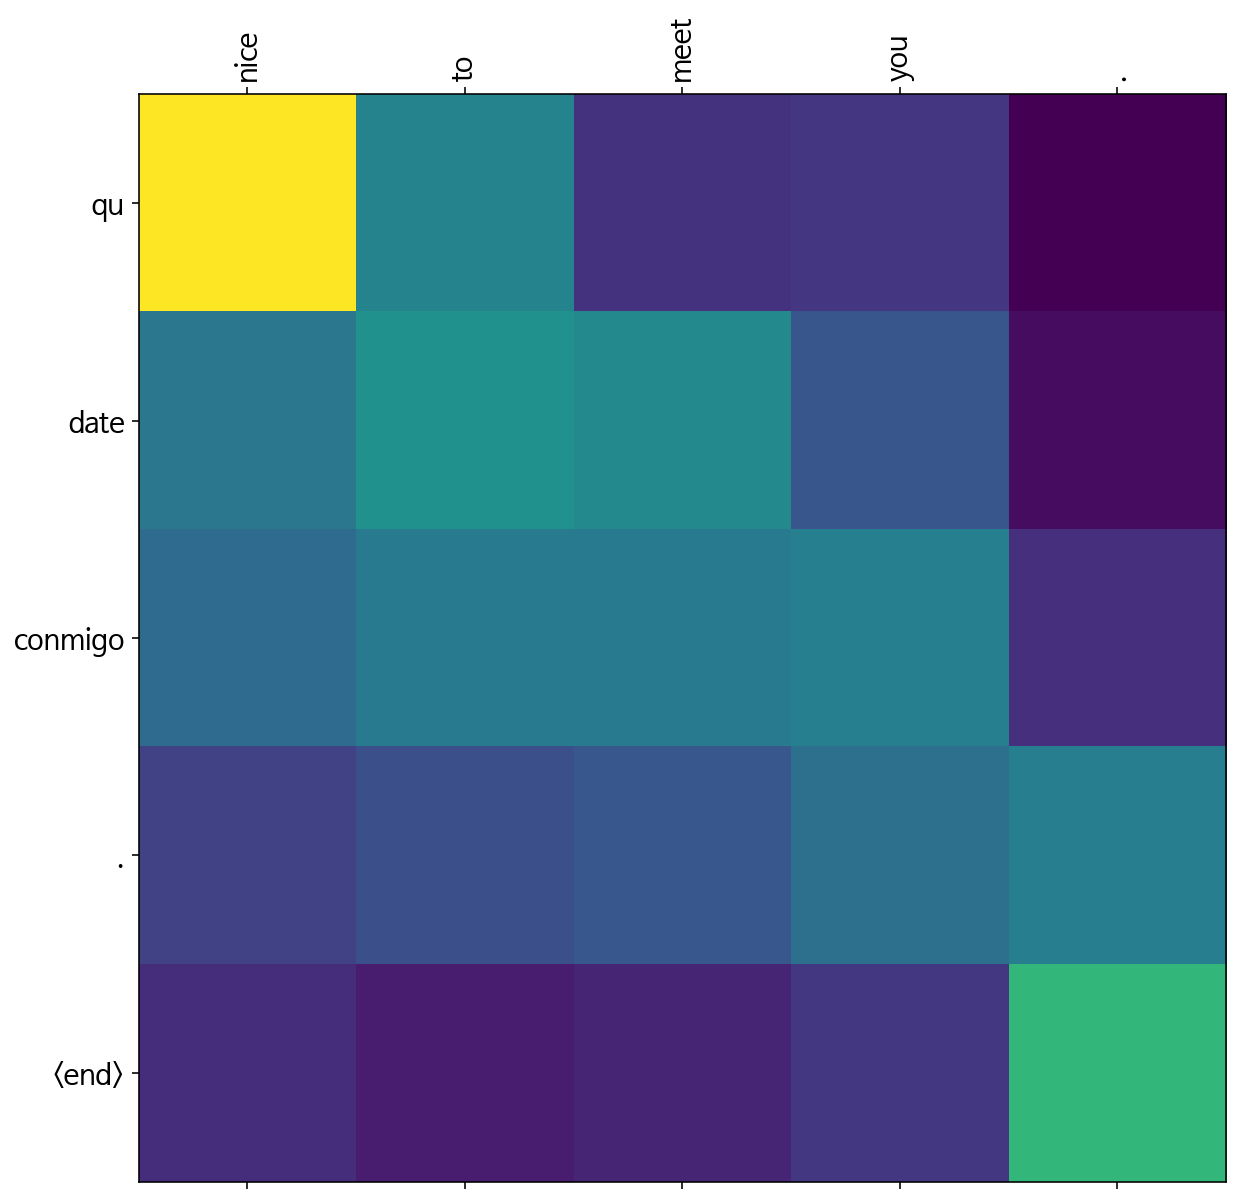

In [21]:
translate("Nice to meet you.", encoder, decoder)

Input: i skipped my lunch yesterday
Predicted translation: me acab el almuerzo del trabajo . <end> 


/tmp/ipykernel_185/1426363336.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_185/1426363336.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


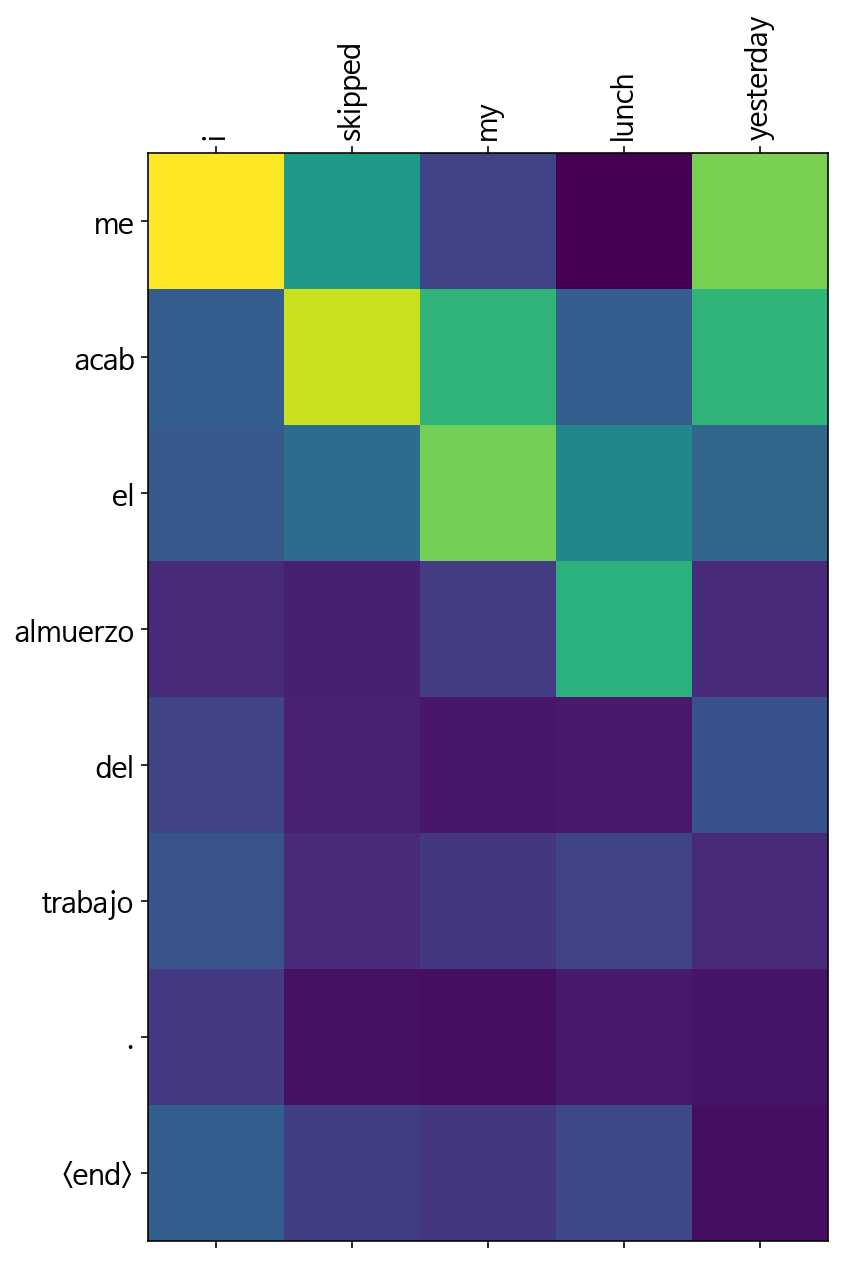

In [23]:
translate("I skipped my lunch yesterday", encoder, decoder)

Input: we want something new .
Predicted translation: deseamos algo nuevo . <end> 


/tmp/ipykernel_185/1426363336.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_185/1426363336.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


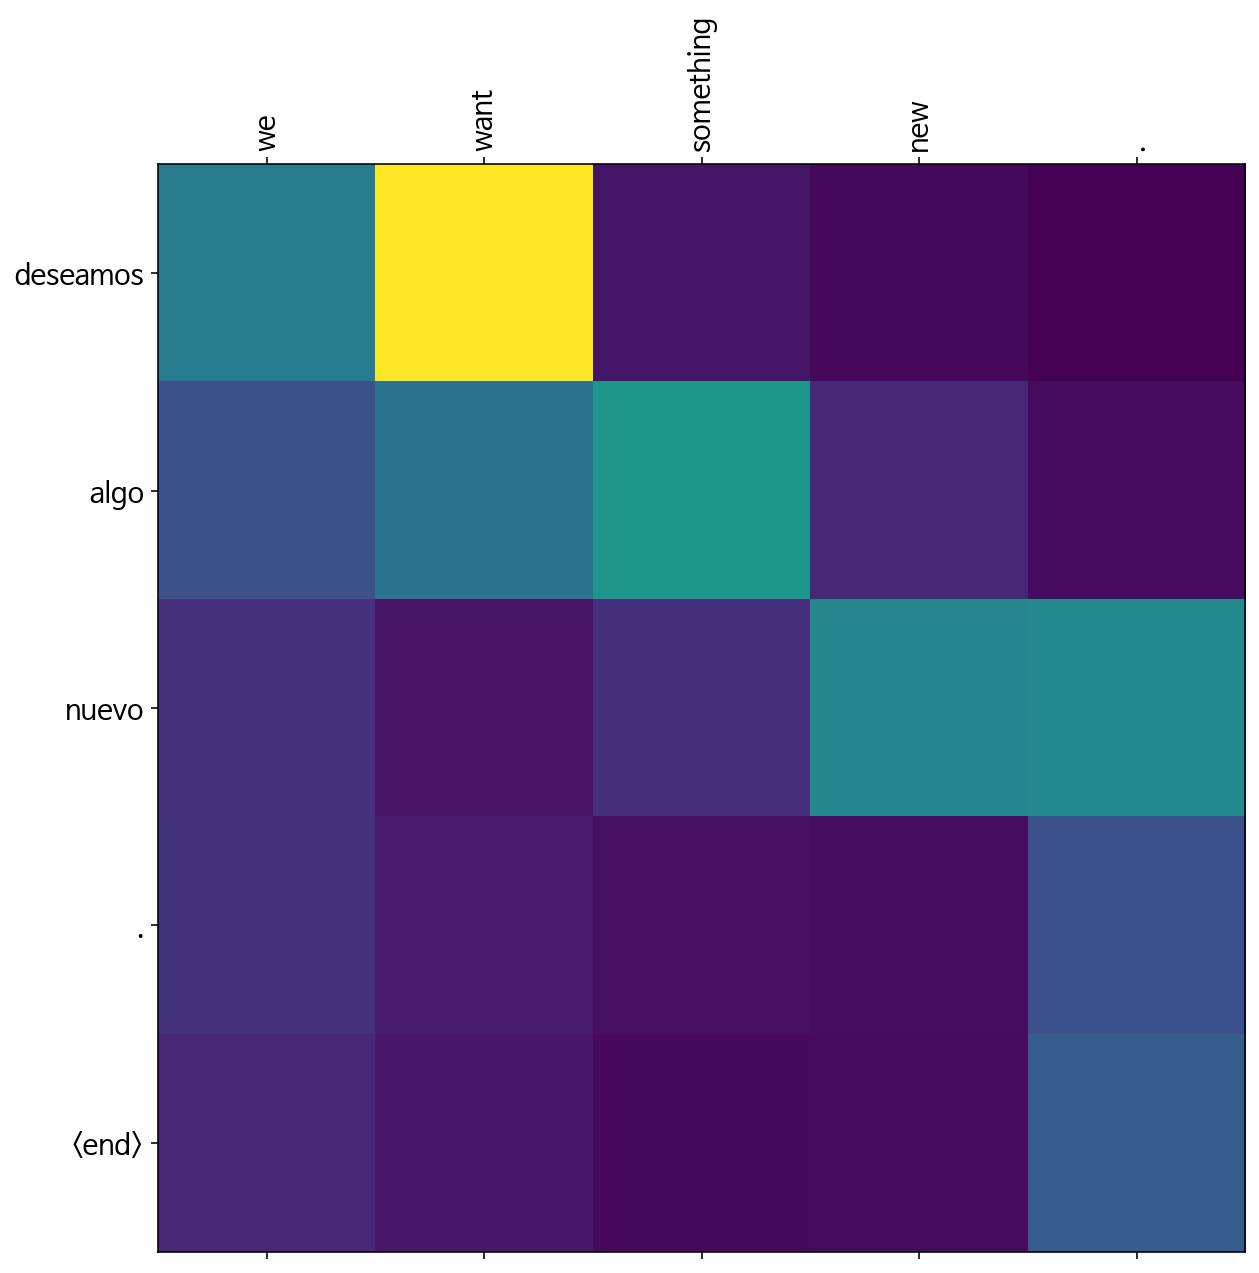

In [24]:
translate("we want something new.", encoder, decoder)

Input: are you happy now ?
Predicted translation: ahora est s contento ? <end> 


/tmp/ipykernel_185/1426363336.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_185/1426363336.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


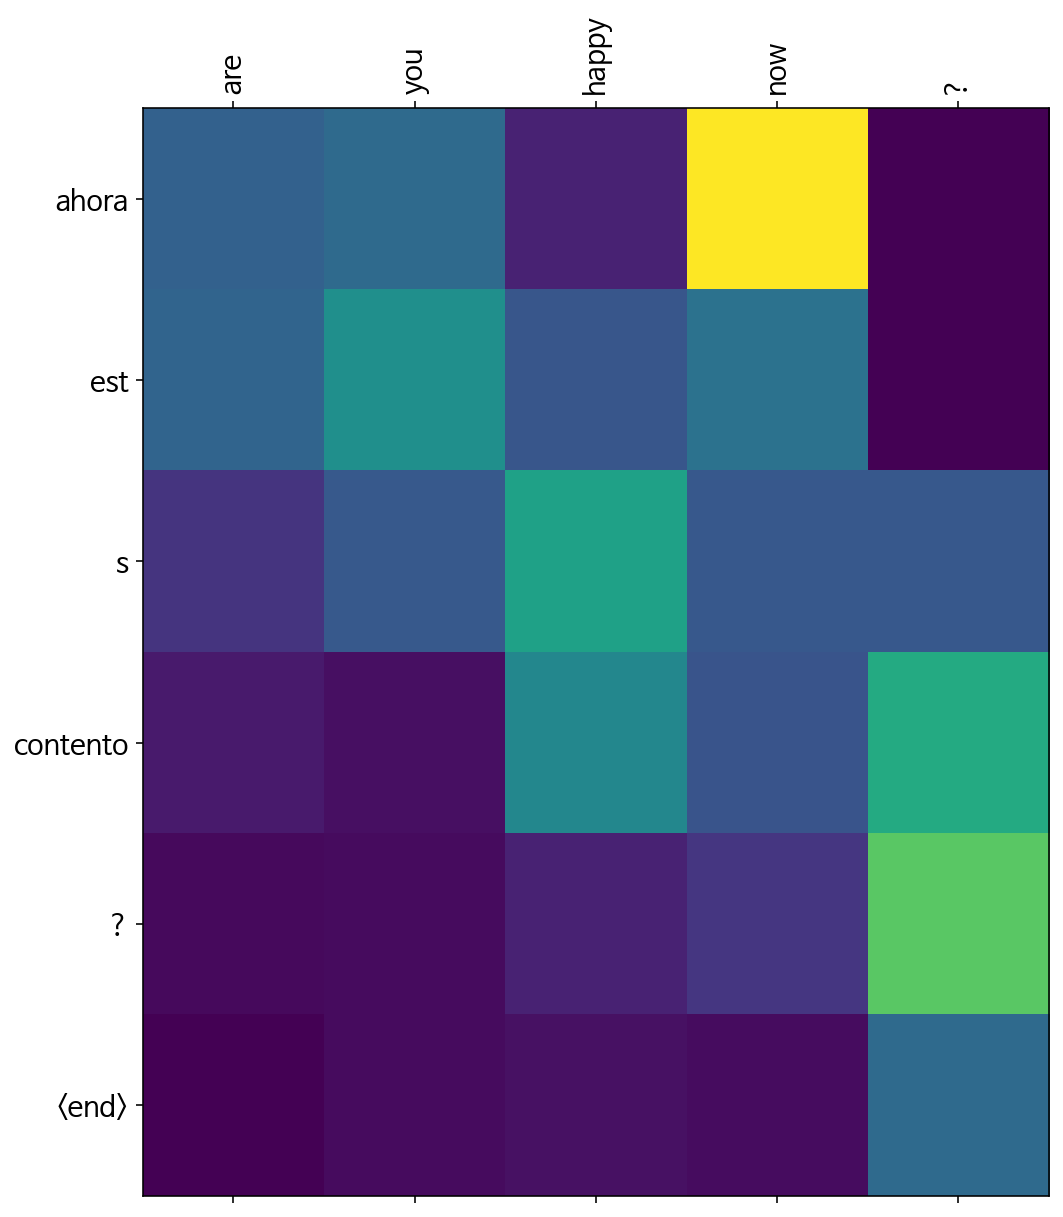

In [26]:
translate("Are you happy now?", encoder, decoder)

Input: he is desperate
Predicted translation: l est desesperado . <end> 


/tmp/ipykernel_185/1426363336.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_185/1426363336.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


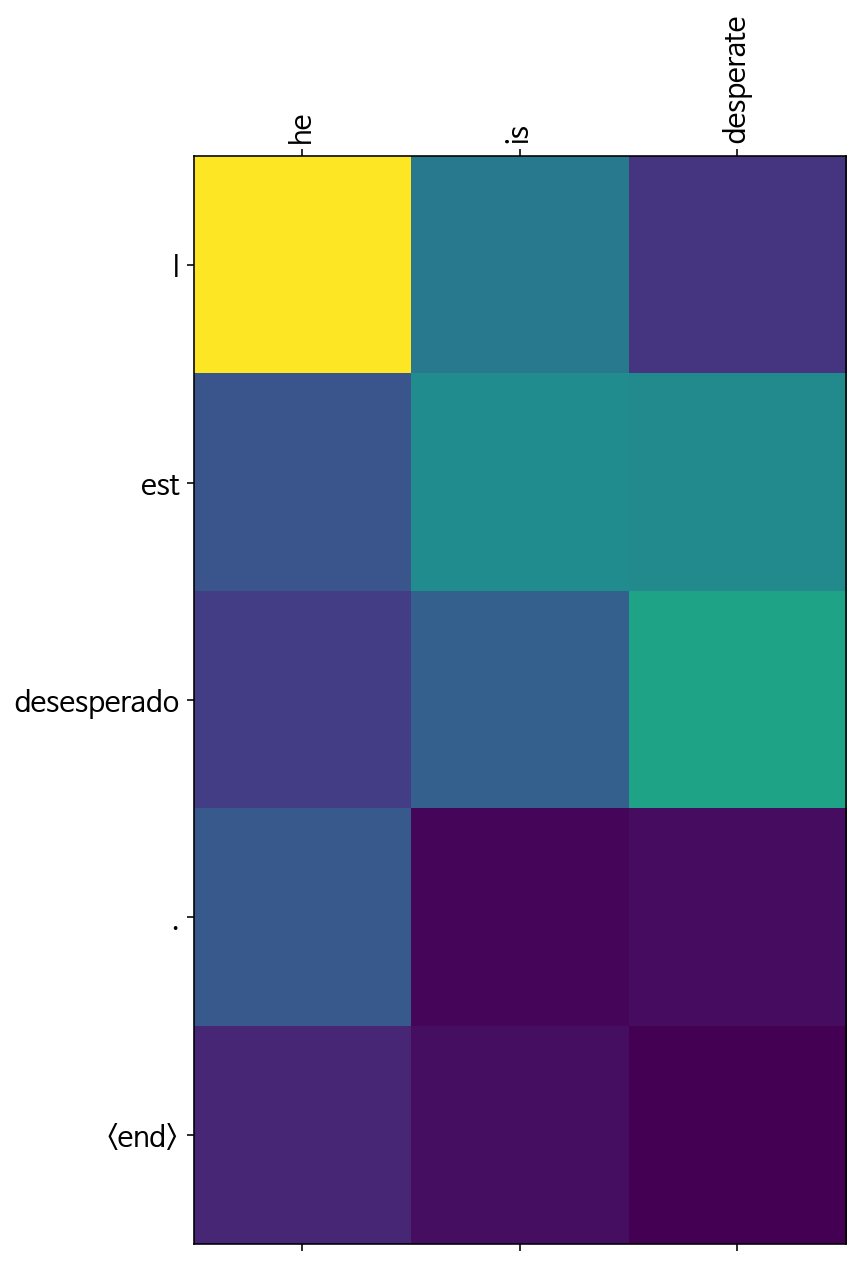

In [35]:
translate("He is desperate", encoder, decoder)

Input: she is happy
Predicted translation: ella es feliz . <end> 


/tmp/ipykernel_185/1426363336.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_185/1426363336.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


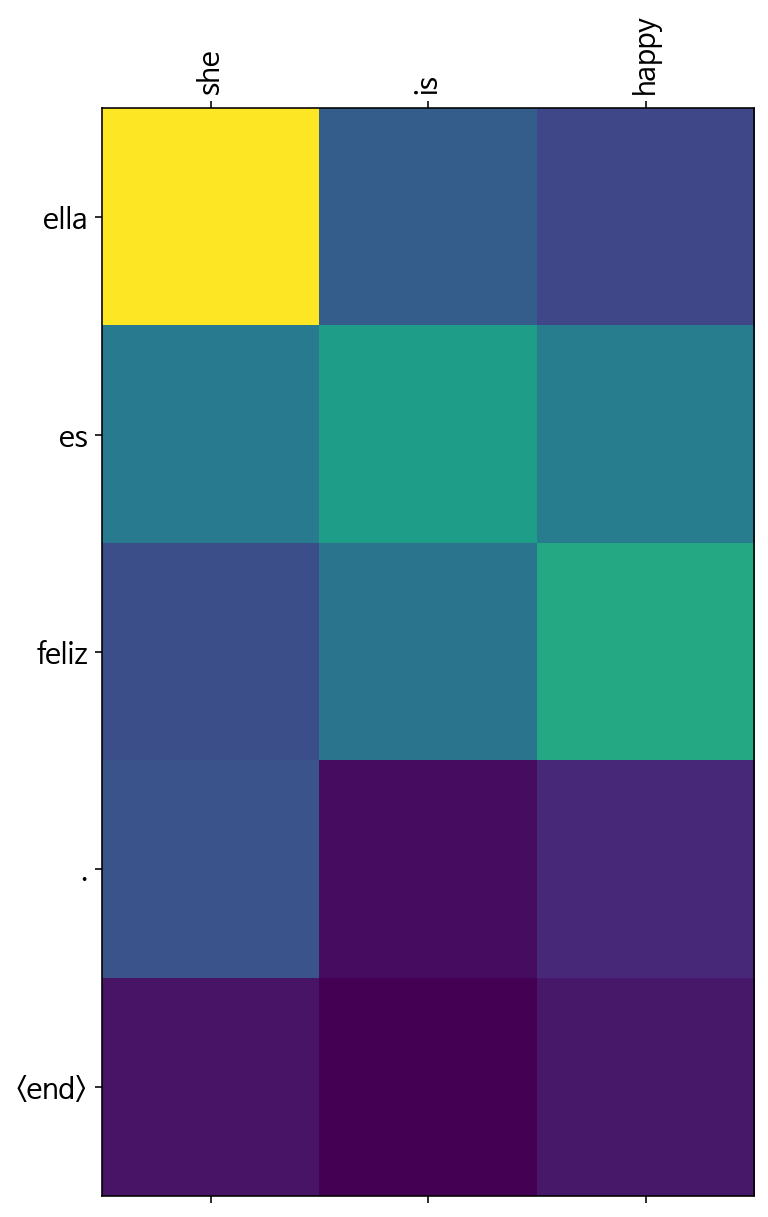

In [34]:
translate("She is happy", encoder, decoder)

Input: european economic area
Predicted translation: el mundo termina . <end> 


/tmp/ipykernel_185/1426363336.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_185/1426363336.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


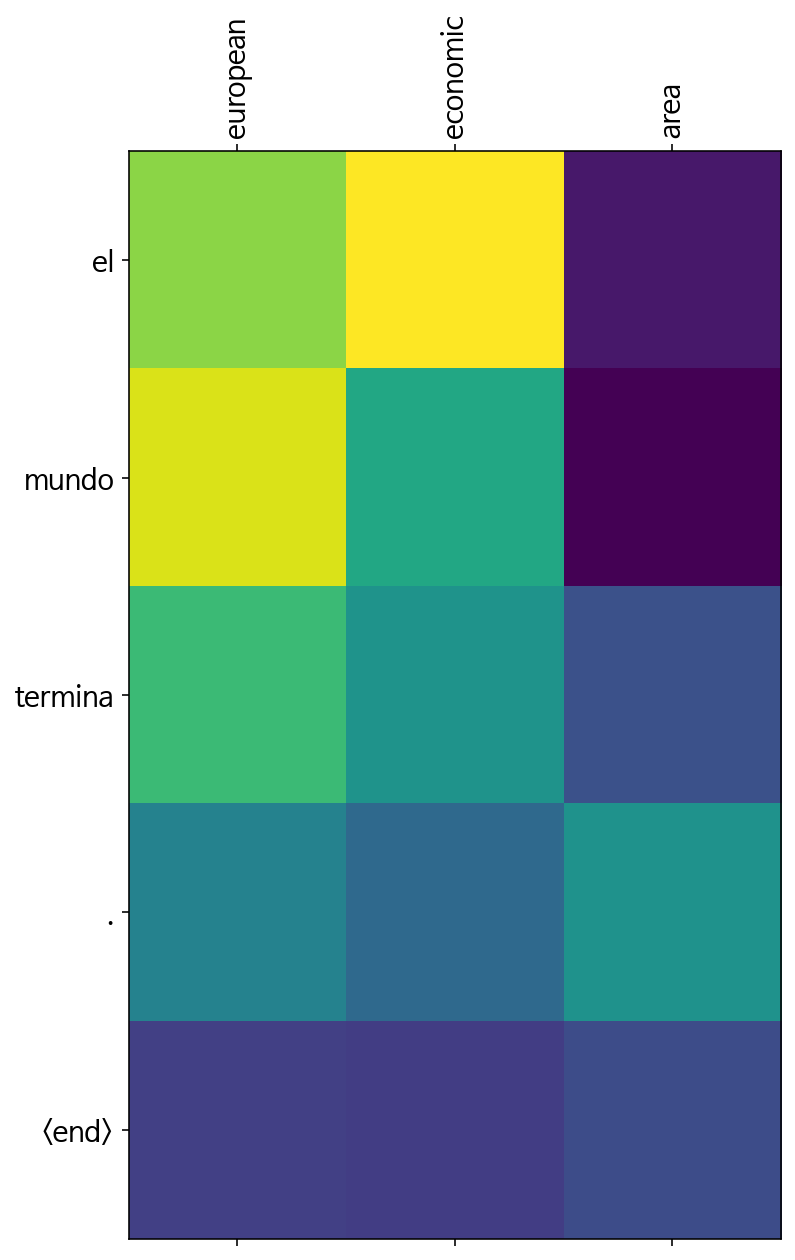

In [27]:
translate("European Economic Area", encoder, decoder)

Input: the agreement on the european economic area was signed august .
Predicted translation: el ni o el ltimo partido . <end> 


/tmp/ipykernel_185/1426363336.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_185/1426363336.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


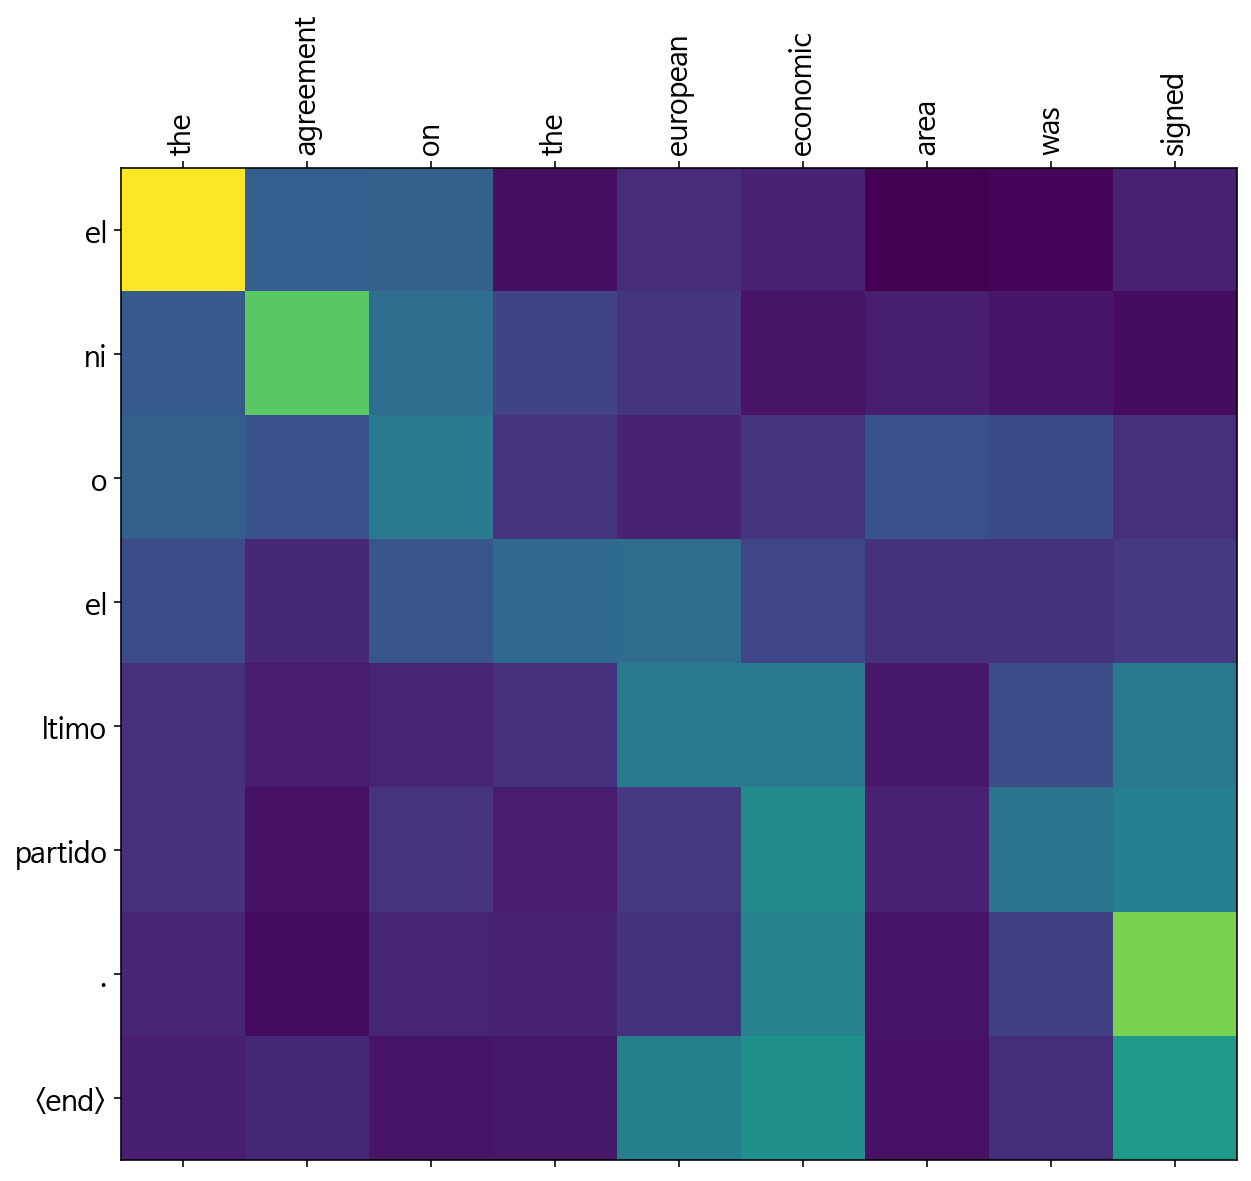

In [19]:
translate("The agreement on the European Economic Area was signed August 1992.", encoder, decoder)